In [20]:
# load std libs
from os import scandir, path, popen
from datetime import datetime

# load third-party libraries
from tqdm import tqdm
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

# load source code
from src.image_loader import load_images
from src.utils import one_hot, shuffle, shuffle_n, get_batch, remove_ticks
from src.networks import LogisticRegression, DenseNet, AlexNet 

# initialization code
np.random.seed(42)
IMG_SIZE = 224

### EDA
Inspect the data a bit. Make sure you've downloaded the training data, unzipped it, and placed it in the `./data/train/raw` directory before running.

,w,h,ratio
0,163,163,1.0
1,886,886,1.0
2,498,498,1.0
3,856,856,1.0
4,300,300,1.0


# of images: 4750 

                 w            h        ratio
count  4750.000000  4750.000000  4750.000000
mean    371.465895   370.730105     1.000364
std     323.275012   318.649607     0.009373
min      49.000000    49.000000     0.943368
25%     140.000000   140.000000     1.000000
50%     266.500000   266.500000     1.000000
75%     507.750000   507.000000     1.000000
max    3991.000000  3457.000000     1.332083


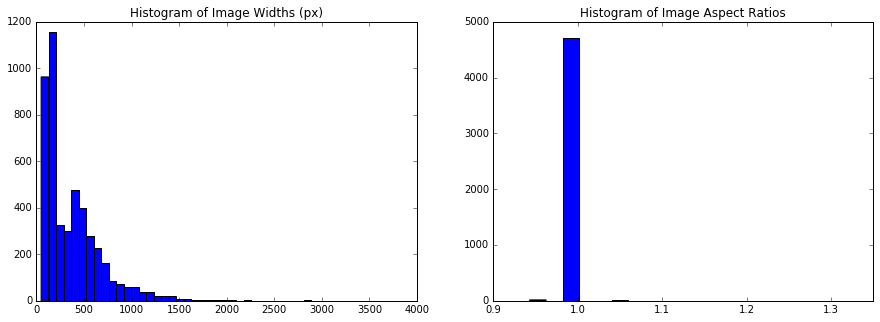

In [39]:
def analyze_image_dimensions():
    # use shell `find` to get all images and exec imagemagick to read the dimensions from the image header
    image_dimensions = !find ./data/train/raw -type f -name '*.png' -exec identify -format '%w %h\n' {} +
    parsed_image_dimensions = (map(int, dims.split(' ')) for dims in image_dimensions)
    image_dims_df = pd.DataFrame(parsed_image_dimensions, columns=("w", "h"))
    image_dims_df["ratio"] = image_dims_df.apply(lambda row: row.w / row.h, axis=1)
    display(image_dims_df.head())

    print("# of images: %d" % len(image_dims_df), "\n")

    print(image_dims_df.describe())

    fig = plt.figure(figsize=(15, 5))
    sub1 = fig.add_subplot(1, 2, 1)
    sub1.hist(image_dims_df.w, bins=50)
    sub1.set_title("Histogram of Image Widths (px)")
    sub2 = fig.add_subplot(1, 2, 2)
    sub2.hist(image_dims_df.ratio, bins=20)
    sub2.set_title("Histogram of Image Aspect Ratios")

analyze_image_dimensions()

There are only 4750 images. This doesn't seem like a lot for only 12 classes.

I've chosen an image size of 224x224 px. This is convenient because many established image recognition networks use inputs of this size, like [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) or [VGG](http://arxiv.org/pdf/1409.1556v6.pdf). However, the images in the training set are myriad of different sizes, which poses a problem. Furthermore, not all the images are square. We need a method for resizing these images and fixing the aspect ratio to 1.

['Charlock', 'Common Chickweed', 'Loose Silky-bent', 'Black-grass', 'Cleavers', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Fat Hen', 'Common wheat', 'Shepherds Purse', 'Sugar beet', 'Maize']


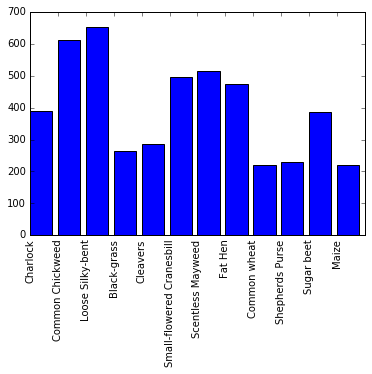

In [36]:
# read the class names from the subdirectories in the training data
class_names = [f.name for f in scandir("./data/train/raw") if f.is_dir()]
print(class_names)

class_counts = []
for class_name in class_names:
    num_examples = popen('ls "./data/train/raw/%s" | grep png | wc -l' % class_name).read().strip()
    class_counts.append(int(num_examples))
    
plt.bar(range(0, len(class_names)), class_counts)
plt.xticks(range(0, len(class_names)), class_names, rotation="vertical")
None

In addition to having few examples, the classes are imbalanced. There are much fewer examples for black-grass, common wheat, shepherd's purse, and maize. This can cause some bias in the classifier, as it is more incentivized to classify things as the classes that appear more frequently in the training set.

### Resize images
Run this once to resize the images and save to disk. This takes around 10sec on an SSD.

Images larger than 224px will be scaled down to this size. For images smaller than this, there is a wider variety of options, like scaling up or zero-padding. Scaling up produced better results on cross validation.

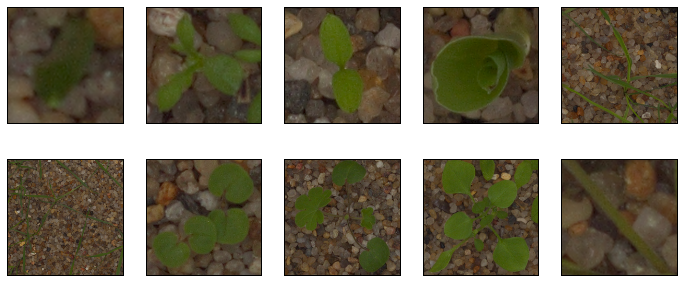

In [8]:
train_imgs = load_images("./data/train/raw/*/*.png", # glob pattern for the images to load
                         desired_size=IMG_SIZE,
                         scale_down=True, # treat images larger than the desired_size by scaling down
                         scale_up=True, # treat images smaller than the desired_size be scaling up
                         write_to="./data/train/resized", # location on disk to save to so we can loaded the images again without resizing every time
                         # this preserves any subdirectories in each path inside the `raw` dir
                         # this is because each subdirectory is the class label, and we still need the labels
                         preserve_dir_tree_at="./data/train/raw")

def plot_random_10(imgs):
    """
    Takes a numpy array representing a batch of images and randomly plots 10 of them
    Args
    ----
    imgs : np.ndarray shape=(batch_length, width, height, channels)
        The batch of images to sample from.
    Return
    ------
    The matplotlib figure.
    """
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i + 1)
        rand_i = np.random.randint(0, len(imgs))
        sub.imshow(imgs[rand_i])
        remove_ticks(sub)
    return fig

plot_random_10(train_imgs)

# delete reference to save memory
del train_imgs

### Load and partition the training data

In [4]:
# collect the images, labels, and individual file paths
# we'll be reloading images later with transformations, so keep track of the image paths that are used for training instead of cross-validation
train_imgs_ord = []
train_labels_ord = []
file_paths_ord = []

for i, name in enumerate(class_names):
    imgs, file_paths = load_images("./data/train/resized/%s/*.png" % name, return_file_paths=True)
    train_imgs_ord.extend(imgs)
    train_labels_ord.extend([i] * len(imgs))
    file_paths_ord.extend(file_paths)

train_imgs_ord = np.array(train_imgs_ord, dtype=np.float32)
print(train_imgs_ord.shape)
train_labels_ord = one_hot(train_labels_ord)
print(train_labels_ord.shape)

['Charlock', 'Common Chickweed', 'Loose Silky-bent', 'Black-grass', 'Cleavers', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Fat Hen', 'Common wheat', 'Shepherds Purse', 'Sugar beet', 'Maize']
(4750, 224, 224, 3)
(4750, 12)


In [5]:
dev_fraction = 0.15
num_dev_examples = math.floor(len(train_imgs_ord) * dev_fraction)
train_imgs_shuf, train_labels_shuf, file_paths_shuf = shuffle_n(train_imgs_ord, train_labels_ord, file_paths_ord)
train_data, train_labels, train_file_paths = (train_imgs_shuf[:-num_dev_examples],
                                              train_labels_shuf[:-num_dev_examples],
                                              file_paths_shuf[:-num_dev_examples])
dev_data, dev_labels, _ = (train_imgs_shuf[-num_dev_examples:],
                           train_labels_shuf[-num_dev_examples:],
                           file_paths_shuf[-num_dev_examples:])

# delete unused varaibles to save memory. yes, this is important for later!
del train_imgs_ord, train_labels_ord, file_paths_ord, train_imgs_shuf, train_labels_shuf, file_paths_shuf, imgs, file_paths
print(train_data.shape)
print(train_labels.shape)
print(dev_data.shape)
print(dev_labels.shape)

(4038, 224, 224, 3)
(4038, 12)
(712, 224, 224, 3)
(712, 12)


### Model 1 - Logistic Regression
Logistic Regression is one of the simplest models to try for classification. These are efficient, interpretable, and easy to train. Although Sci-kit Learn is a popular off-the-shelf library for logistic regression, their implementation is very inefficient. It uses the main Python process for all calculations, meaning it all happens serially on a single thread. When I use it on this amount of data, it takes almost half an hour to train. Instead, I'll use a manually coded version in Tensorflow in order to take advantage of the GPU. This speeds up training by orders of magnitude.

In [6]:
batch_size = 128
num_classes = train_labels.shape[1]
# regularization hyper-parameter
beta = 1

# we'll be building serveral different Tensorflow graphs, but they all use mostly the same inputs, so create them in a re-useable function
def create_placeholders(batch_size, num_classes, img_size):
    X = tf.placeholder(tf.float32, shape=(batch_size, IMG_SIZE, IMG_SIZE, 3), name="X")
    Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes), name="Y")
    dropout = tf.placeholder(tf.float16, name="dropout_rate")
    learn_rate = tf.placeholder(tf.float16, name="learning_rate")
    return X, Y, dropout, learn_rate

# the outputs for each graphs are the same too, so put it in a function
def create_outputs(learn_rate, loss, logits, Y):
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learn_rate)
        optimization_op = optimizer.minimize(loss)

    # write this to Tensorboard for visualization
    tf.summary.scalar('loss', loss)

    with tf.name_scope("accuracy"):
        predictions = tf.argmax(model.logits, axis=1)
        correct_predictions = tf.equal(predictions, tf.argmax(Y, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    # also visualize the training accuracy
    tf.summary.scalar('training_accuracy', accuracy)

    merged_summary = tf.summary.merge_all()
    # this lets us save/load models in tensorflow sessions
    saver = tf.train.Saver()
    
    return optimization_op, predictions, accuracy, merged_summary, saver

tf.reset_default_graph()
X, Y, dropout, learn_rate = create_placeholders(batch_size, num_classes, IMG_SIZE)

model = LogisticRegression(X, num_classes)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y))
# use L2 regularization to mitigate over-fitting
regularizer = tf.nn.l2_loss(model.W)
loss += regularizer * beta

optimization_op, predictions, accuracy, merged_summary, saver = create_outputs(learn_rate, loss, model.logits, Y)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
def train_and_evaluate(train_data, train_labels, dev_data, dev_labels, learning_rate, num_epochs, dropout_rate=0.5, display_step=10, log_prefix="run0"):
    """
    Train the default Tensorflow graph and evaluate the training and dev accuracy. Training accuracy is streamed to Tensorbaord,
    Google's visualization tool. Dev accuracy is printed to stdout.
    Args
    ----
    train_data : np.ndarray (m, img_wid, img_hgt, channels)
        The training data
    train_labels : np.ndarray (m, num_classes)
        The training data labels, with one-hot encoding
    dev_data : np.ndarray (m, img_wid, img_hgt, channels)
        The cross validation data
    dev_labels : np.ndarray (m, num_classes)
        The labels for cross validation data, one-hot encoded
    learning_rate : float
    num_epochs : int
        How many passes over training data
    dropout_rate : float [=0.5]
        For neural networks, the probability of "dropout", a regularization technique
    display_step : int [=10]
        How many batches of training between each point to plot for the tensorboard graphs of loss and training acc
    log_prefix : string [="run0"]
        A name for the "run" in tensorboard
    """
    
    training_batches_per_epoch = int(np.floor(train_data.shape[0] / batch_size))
    dev_batches_per_epoch = int(np.floor(dev_data.shape[0] / batch_size))
    
    # where to write the summary so tensorboard can visualize
    writer = tf.summary.FileWriter("./tensorboard/" + log_prefix)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)

        for epoch in range(num_epochs):
            print("{} epoch number: {}".format(datetime.now(), epoch + 1))
            shuffle(train_data, train_labels)
            
            for step in tqdm(range(training_batches_per_epoch)):
                x_batch, y_batch = get_batch(train_data, train_labels, step, batch_size)
                sess.run(optimization_op, feed_dict={X: x_batch, Y: y_batch, dropout: dropout_rate, learn_rate: learning_rate })

                # every so often, report the progress of our loss and training accuracy
                if step % display_step == 0:
                    summ = sess.run(merged_summary, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                    writer.add_summary(summ, epoch * training_batches_per_epoch + step)
                    writer.flush()

            # calculate the dev accuracy after each epoch
            dev_acc = 0
            dev_count = 0
            for step in range(dev_batches_per_epoch):
                x_batch, y_batch = get_batch(dev_data, dev_labels, step, batch_size)
                acc = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                dev_acc += acc
                dev_count += 1

            print("dev accuracy = {:.4f}".format(dev_acc / dev_count))

        # save the model to disk so we can load it up later for prediction
        saver.save(sess, "./tensorflow-ckpt/model.ckpt")

In [9]:
train_and_evaluate(train_data, train_labels, dev_data, dev_labels,
                   learning_rate=1e-5,
                   num_epochs=30,
                   display_step=20,
                   log_prefix="run1")

2018-03-11 01:25:25.155119 epoch number: 1


100%|██████████| 31/31 [00:01<00:00, 23.74it/s]


dev accuracy = 0.1688
2018-03-11 01:25:27.212301 epoch number: 2


100%|██████████| 31/31 [00:01<00:00, 25.85it/s]


dev accuracy = 0.2328
2018-03-11 01:25:29.154654 epoch number: 3


100%|██████████| 31/31 [00:01<00:00, 25.90it/s]


dev accuracy = 0.2531
2018-03-11 01:25:31.100077 epoch number: 4


100%|██████████| 31/31 [00:01<00:00, 25.88it/s]


dev accuracy = 0.2578
2018-03-11 01:25:33.045968 epoch number: 5


100%|██████████| 31/31 [00:01<00:00, 25.75it/s]


dev accuracy = 0.2266
2018-03-11 01:25:34.990781 epoch number: 6


100%|██████████| 31/31 [00:01<00:00, 25.92it/s]


dev accuracy = 0.2469
2018-03-11 01:25:36.931328 epoch number: 7


100%|██████████| 31/31 [00:01<00:00, 25.92it/s]


dev accuracy = 0.2531
2018-03-11 01:25:38.870509 epoch number: 8


100%|██████████| 31/31 [00:01<00:00, 25.94it/s]


dev accuracy = 0.3156
2018-03-11 01:25:40.819420 epoch number: 9


100%|██████████| 31/31 [00:01<00:00, 25.90it/s]


dev accuracy = 0.2766
2018-03-11 01:25:42.765743 epoch number: 10


100%|██████████| 31/31 [00:01<00:00, 25.87it/s]


dev accuracy = 0.3047
2018-03-11 01:25:44.706201 epoch number: 11


100%|██████████| 31/31 [00:01<00:00, 25.91it/s]


dev accuracy = 0.3281
2018-03-11 01:25:46.645497 epoch number: 12


100%|██████████| 31/31 [00:01<00:00, 25.86it/s]


dev accuracy = 0.2719
2018-03-11 01:25:48.592682 epoch number: 13


100%|██████████| 31/31 [00:01<00:00, 25.87it/s]


dev accuracy = 0.3141
2018-03-11 01:25:50.540649 epoch number: 14


100%|██████████| 31/31 [00:01<00:00, 25.81it/s]


dev accuracy = 0.2953
2018-03-11 01:25:52.482632 epoch number: 15


100%|██████████| 31/31 [00:01<00:00, 25.91it/s]


dev accuracy = 0.2953
2018-03-11 01:25:54.427904 epoch number: 16


100%|██████████| 31/31 [00:01<00:00, 25.97it/s]


dev accuracy = 0.3359
2018-03-11 01:25:56.370149 epoch number: 17


100%|██████████| 31/31 [00:01<00:00, 25.84it/s]


dev accuracy = 0.3219
2018-03-11 01:25:58.315394 epoch number: 18


100%|██████████| 31/31 [00:01<00:00, 25.90it/s]


dev accuracy = 0.3656
2018-03-11 01:26:00.272803 epoch number: 19


100%|██████████| 31/31 [00:01<00:00, 25.86it/s]


dev accuracy = 0.3422
2018-03-11 01:26:02.225560 epoch number: 20


100%|██████████| 31/31 [00:01<00:00, 25.99it/s]


dev accuracy = 0.3203
2018-03-11 01:26:04.174059 epoch number: 21


100%|██████████| 31/31 [00:01<00:00, 25.91it/s]


dev accuracy = 0.2797
2018-03-11 01:26:06.119517 epoch number: 22


100%|██████████| 31/31 [00:01<00:00, 25.88it/s]


dev accuracy = 0.3453
2018-03-11 01:26:08.061637 epoch number: 23


100%|██████████| 31/31 [00:01<00:00, 25.94it/s]


dev accuracy = 0.3422
2018-03-11 01:26:10.004145 epoch number: 24


100%|██████████| 31/31 [00:01<00:00, 25.81it/s]


dev accuracy = 0.3344
2018-03-11 01:26:11.948761 epoch number: 25


100%|██████████| 31/31 [00:01<00:00, 25.86it/s]


dev accuracy = 0.3297
2018-03-11 01:26:13.889740 epoch number: 26


100%|██████████| 31/31 [00:01<00:00, 25.72it/s]


dev accuracy = 0.3359
2018-03-11 01:26:15.842585 epoch number: 27


100%|██████████| 31/31 [00:01<00:00, 25.79it/s]


dev accuracy = 0.3125
2018-03-11 01:26:17.798568 epoch number: 28


100%|██████████| 31/31 [00:01<00:00, 25.79it/s]


dev accuracy = 0.3141
2018-03-11 01:26:19.750701 epoch number: 29


100%|██████████| 31/31 [00:01<00:00, 25.67it/s]


dev accuracy = 0.3172
2018-03-11 01:26:21.709388 epoch number: 30


100%|██████████| 31/31 [00:01<00:00, 25.85it/s]


dev accuracy = 0.3719


After searching for optimal `beta` value, Tensorboard visualizations showed only slightly higher training accuracy compared to the dev accuracy of about 37%. The dev accuracy remains low, even with more epochs. This suggests under-fitting. This is not surprising as the model is very simple. It is using linear combinations of products of coefficients and individual pixel values, to determine probabilities of classes. Such a model would be over-sensitive to positions, poses, zoom levels, etc. which all widely vary between images in the same class. Therefore, a more complex model is needed.

### Model 2 - Multi-layer Perceptron
Deep learning is capable of learning more complex, non-linear logic. This time I'll try a multi-layer perceptron, which is a deep neural network with all "fully connected" layers. Each pixel is treated as a feature, and the image is flattened to a vector of these pixels as input to the neural network.

In [6]:
tf.reset_default_graph()
X, Y, dropout, learn_rate = create_placeholders(batch_size, num_classes, IMG_SIZE)

model = DenseNet(X, dropout, num_classes)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y))
optimization_op, predictions, accuracy, merged_summary, saver = create_outputs(learn_rate, loss, model.logits, Y)

In [9]:
train_and_evaluate(train_data, train_labels, dev_data, dev_labels,
                   learning_rate=1e-5,
                   num_epochs=30,
                   display_step=20,
                   dropout_rate=0.3,
                   log_prefix="run2")

2018-03-11 01:32:52.234125 epoch number: 1


100%|██████████| 31/31 [00:02<00:00, 15.15it/s]


dev accuracy = 0.2062
2018-03-11 01:32:55.064998 epoch number: 2


100%|██████████| 31/31 [00:02<00:00, 15.33it/s]


dev accuracy = 0.1906
2018-03-11 01:32:57.869228 epoch number: 3


100%|██████████| 31/31 [00:02<00:00, 15.36it/s]


dev accuracy = 0.2469
2018-03-11 01:33:00.669564 epoch number: 4


100%|██████████| 31/31 [00:02<00:00, 15.26it/s]


dev accuracy = 0.2687
2018-03-11 01:33:03.484384 epoch number: 5


100%|██████████| 31/31 [00:02<00:00, 15.28it/s]


dev accuracy = 0.2922
2018-03-11 01:33:06.289485 epoch number: 6


100%|██████████| 31/31 [00:02<00:00, 15.25it/s]


dev accuracy = 0.3141
2018-03-11 01:33:09.116306 epoch number: 7


100%|██████████| 31/31 [00:02<00:00, 15.27it/s]


dev accuracy = 0.2938
2018-03-11 01:33:11.921986 epoch number: 8


100%|██████████| 31/31 [00:02<00:00, 15.47it/s]


dev accuracy = 0.3312
2018-03-11 01:33:14.708130 epoch number: 9


100%|██████████| 31/31 [00:02<00:00, 15.45it/s]


dev accuracy = 0.3453
2018-03-11 01:33:17.493183 epoch number: 10


100%|██████████| 31/31 [00:02<00:00, 15.47it/s]


dev accuracy = 0.3125
2018-03-11 01:33:20.294757 epoch number: 11


100%|██████████| 31/31 [00:02<00:00, 15.40it/s]


dev accuracy = 0.3969
2018-03-11 01:33:23.078565 epoch number: 12


100%|██████████| 31/31 [00:02<00:00, 15.41it/s]


dev accuracy = 0.3688
2018-03-11 01:33:25.858677 epoch number: 13


100%|██████████| 31/31 [00:02<00:00, 15.47it/s]


dev accuracy = 0.3828
2018-03-11 01:33:28.635657 epoch number: 14


100%|██████████| 31/31 [00:02<00:00, 15.32it/s]


dev accuracy = 0.3719
2018-03-11 01:33:31.430523 epoch number: 15


100%|██████████| 31/31 [00:02<00:00, 15.40it/s]


dev accuracy = 0.3828
2018-03-11 01:33:34.216780 epoch number: 16


100%|██████████| 31/31 [00:02<00:00, 15.40it/s]


dev accuracy = 0.4281
2018-03-11 01:33:37.004107 epoch number: 17


100%|██████████| 31/31 [00:02<00:00, 15.47it/s]


dev accuracy = 0.4313
2018-03-11 01:33:39.789842 epoch number: 18


100%|██████████| 31/31 [00:02<00:00, 15.43it/s]


dev accuracy = 0.4609
2018-03-11 01:33:42.582074 epoch number: 19


100%|██████████| 31/31 [00:02<00:00, 15.45it/s]


dev accuracy = 0.4453
2018-03-11 01:33:45.368516 epoch number: 20


100%|██████████| 31/31 [00:02<00:00, 15.30it/s]


dev accuracy = 0.4672
2018-03-11 01:33:48.168865 epoch number: 21


100%|██████████| 31/31 [00:02<00:00, 15.31it/s]


dev accuracy = 0.4203
2018-03-11 01:33:50.974641 epoch number: 22


100%|██████████| 31/31 [00:02<00:00, 15.36it/s]


dev accuracy = 0.4844
2018-03-11 01:33:53.775479 epoch number: 23


100%|██████████| 31/31 [00:02<00:00, 15.45it/s]


dev accuracy = 0.4766
2018-03-11 01:33:56.563057 epoch number: 24


100%|██████████| 31/31 [00:02<00:00, 15.39it/s]


dev accuracy = 0.4688
2018-03-11 01:33:59.357988 epoch number: 25


100%|██████████| 31/31 [00:02<00:00, 15.31it/s]


dev accuracy = 0.4641
2018-03-11 01:34:02.186647 epoch number: 26


100%|██████████| 31/31 [00:02<00:00, 15.32it/s]


dev accuracy = 0.4641
2018-03-11 01:34:05.005622 epoch number: 27


100%|██████████| 31/31 [00:02<00:00, 15.39it/s]


dev accuracy = 0.4437
2018-03-11 01:34:07.804051 epoch number: 28


100%|██████████| 31/31 [00:02<00:00, 15.30it/s]


dev accuracy = 0.4766
2018-03-11 01:34:10.612639 epoch number: 29


100%|██████████| 31/31 [00:02<00:00, 15.32it/s]


dev accuracy = 0.4719
2018-03-11 01:34:13.412218 epoch number: 30


100%|██████████| 31/31 [00:01<00:00, 15.51it/s]


dev accuracy = 0.4562


This model gets better performance, about 46%. However, this still isn't very good. This model treats each pixel as an independent feature, discarding the 2-D spatial locality of neighbooring pixels. It also lacks translational and rotational invariance. A model more suitable for image is [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network).

### Model 3 - AlexNet
First, I'll try a simple but well-establish architecture: AlexNet.

In [11]:
tf.reset_default_graph()
X, Y, dropout, learn_rate = create_placeholders(batch_size, num_classes, IMG_SIZE)

model = AlexNet(X, dropout, num_classes)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y))

optimization_op, predictions, accuracy, merged_summary, saver = create_outputs(learn_rate, loss, model.logits, Y)

In [13]:
train_and_evaluate(train_data, train_labels, dev_data, dev_labels,
                   learning_rate=7e-5,
                   num_epochs=30,
                   dropout_rate=0.5,
                   display_step=20,
                   log_prefix="run3")

2018-03-11 01:38:24.478119 epoch number: 1


100%|██████████| 31/31 [00:06<00:00,  4.87it/s]


dev accuracy = 0.1859
2018-03-11 01:38:31.964678 epoch number: 2


100%|██████████| 31/31 [00:06<00:00,  4.90it/s]


dev accuracy = 0.3219
2018-03-11 01:38:39.378012 epoch number: 3


100%|██████████| 31/31 [00:06<00:00,  4.90it/s]


dev accuracy = 0.3953
2018-03-11 01:38:46.784540 epoch number: 4


100%|██████████| 31/31 [00:06<00:00,  4.90it/s]


dev accuracy = 0.4656
2018-03-11 01:38:54.193071 epoch number: 5


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.4750
2018-03-11 01:39:01.614029 epoch number: 6


100%|██████████| 31/31 [00:06<00:00,  4.90it/s]


dev accuracy = 0.5516
2018-03-11 01:39:09.035386 epoch number: 7


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.5797
2018-03-11 01:39:16.463045 epoch number: 8


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.6594
2018-03-11 01:39:23.883959 epoch number: 9


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.6516
2018-03-11 01:39:31.307899 epoch number: 10


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7109
2018-03-11 01:39:38.735464 epoch number: 11


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7297
2018-03-11 01:39:46.161666 epoch number: 12


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7328
2018-03-11 01:39:53.589195 epoch number: 13


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


dev accuracy = 0.7578
2018-03-11 01:40:01.022311 epoch number: 14


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7484
2018-03-11 01:40:08.446969 epoch number: 15


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7781
2018-03-11 01:40:15.868620 epoch number: 16


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


dev accuracy = 0.7594
2018-03-11 01:40:23.307283 epoch number: 17


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


dev accuracy = 0.8094
2018-03-11 01:40:30.739076 epoch number: 18


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7656
2018-03-11 01:40:38.168695 epoch number: 19


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7891
2018-03-11 01:40:45.588383 epoch number: 20


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.8000
2018-03-11 01:40:53.031252 epoch number: 21


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


dev accuracy = 0.7922
2018-03-11 01:41:00.468905 epoch number: 22


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.8234
2018-03-11 01:41:07.892170 epoch number: 23


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.8219
2018-03-11 01:41:15.326348 epoch number: 24


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7750
2018-03-11 01:41:22.749865 epoch number: 25


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.8125
2018-03-11 01:41:30.185493 epoch number: 26


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


dev accuracy = 0.7937
2018-03-11 01:41:37.618460 epoch number: 27


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


dev accuracy = 0.8109
2018-03-11 01:41:45.050021 epoch number: 28


100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


dev accuracy = 0.8156
2018-03-11 01:41:52.498994 epoch number: 29


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.7984
2018-03-11 01:41:59.927616 epoch number: 30


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


dev accuracy = 0.8344


Performance is much better, exceeding 80%. However, the Tensorboard dashboard shows a much higher training accuracy, even with a dropout rate of `0.5`. This suggests over-fitting. Other than dropout, another method for addressing over-fitting is to train with more data. Of course, I cannot request more training data. Instead, I can "create" some by applying transformations to existing data, such as rotations and reflection—things which the model *should* be invariant to. This is known as "augmentation".

In [8]:
def augment(data, labels):
    # generate the mirror images
    mirror_data = data[:, :, ::-1, :]
    data_aug = np.concatenate((data, mirror_data))

    # generate rotations
    rot90 = np.rot90(data_aug, axes=(1, 2))
    rot180 = np.rot90(rot90, axes=(1, 2))
    rot270 = np.rot90(rot180, axes=(1, 2))
    data_aug = np.concatenate((data_aug, rot90, rot180, rot270))
    
    labels_aug = np.tile(labels, (8, 1))

    return data_aug, labels_aug

train_data_aug, train_labels_aug = augment(train_data, train_labels)
print(train_data_aug.shape)
print(train_labels_aug.shape)

(32304, 224, 224, 3)
(32304, 12)


In [9]:
train_and_evaluate(train_data_aug, train_labels_aug, dev_data, dev_labels,
                   learning_rate=1e-5,
                   num_epochs=20,
                   dropout_rate=0.5,
                   display_step=20,
                   log_prefix="run4")

2018-03-10 11:20:54.175380 epoch number: 1


100%|██████████| 252/252 [00:50<00:00,  4.94it/s]


dev accuracy = 0.4313
2018-03-10 11:21:50.261163 epoch number: 2


100%|██████████| 252/252 [00:51<00:00,  4.93it/s]


dev accuracy = 0.5094
2018-03-10 11:22:46.457243 epoch number: 3


100%|██████████| 252/252 [00:51<00:00,  4.93it/s]


dev accuracy = 0.5859
2018-03-10 11:23:42.622167 epoch number: 4


100%|██████████| 252/252 [00:51<00:00,  4.93it/s]


dev accuracy = 0.6438
2018-03-10 11:24:38.785807 epoch number: 5


100%|██████████| 252/252 [00:51<00:00,  4.93it/s]


dev accuracy = 0.7094
2018-03-10 11:25:34.932999 epoch number: 6


100%|██████████| 252/252 [00:51<00:00,  4.93it/s]


dev accuracy = 0.7422
2018-03-10 11:26:31.157062 epoch number: 7


100%|██████████| 252/252 [00:51<00:00,  4.93it/s]


dev accuracy = 0.7594
2018-03-10 11:27:27.359886 epoch number: 8


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.7937
2018-03-10 11:28:23.633706 epoch number: 9


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8234
2018-03-10 11:29:19.902704 epoch number: 10


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8234
2018-03-10 11:30:16.160050 epoch number: 11


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8234
2018-03-10 11:31:12.454161 epoch number: 12


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8250
2018-03-10 11:32:08.718036 epoch number: 13


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8516
2018-03-10 11:33:05.064176 epoch number: 14


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8500
2018-03-10 11:34:01.307297 epoch number: 15


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8594
2018-03-10 11:34:57.554660 epoch number: 16


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8609
2018-03-10 11:35:53.828174 epoch number: 17


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8625
2018-03-10 11:36:50.089350 epoch number: 18


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8562
2018-03-10 11:37:46.400184 epoch number: 19


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8656
2018-03-10 11:38:42.697973 epoch number: 20


100%|██████████| 252/252 [00:51<00:00,  4.92it/s]


dev accuracy = 0.8781


This afforded another significant boost in performance. The gap between the training and dev accuracy is much smaller, suggesting that the over-fitting issues are fixed. I'll see if I can squeeze out more performance by augmenting the data even further.

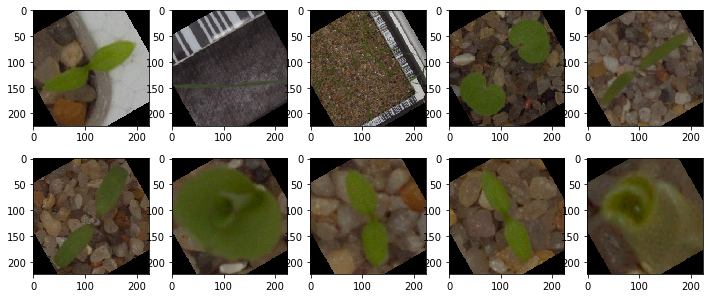

In [10]:
# `train_file_paths` holds the file paths of the images selected for training, not cross-validation
rotated_imgs = load_images(train_file_paths,
                           desired_size=IMG_SIZE,
                           scale_down=True,
                           scale_up=True,
                           rotate=30,
                           write_to="./data/train/rotated",
                           preserve_dir_tree_at="./data/train/resized")

plot_random_10(rotated_imgs)

del rotated_imgs

In [11]:
# generate 30 degree rotations of the training data an apply the same transformations as before: reflections and 90 degree rotations

train_imgs_rot = []
train_labels_rot = []

for i, name in enumerate(class_names):
    imgs = load_images("./data/train/rotated/%s/*.png" % name)
    train_imgs_rot.extend(imgs)
    train_labels_rot.extend([i] * len(imgs))

train_imgs_rot = np.array(train_imgs_rot, dtype=np.float32)

train_imgs_rot, train_labels_rot = augment(train_imgs_rot, 
                                           one_hot(train_labels_rot))

# put everything together
train_data_aug_2 = np.concatenate((train_data_aug, train_imgs_rot))
train_labels_aug_2 = np.concatenate((train_labels_aug, train_labels_rot))

# remove unused variables to save memory
del train_data_aug, train_labels_aug, train_data, train_labels, train_file_paths, train_imgs_rot, train_labels_rot

print(train_data_aug_2.shape)
print(train_labels_aug_2.shape)

(64608, 224, 224, 3)
(64608, 12)


### Memory Issues
At this point, the program is consuming about 60GB of memory. The machine I'm traning on has 64GB of RAM. Some memory is getting moved into SWAP, like the memory allocated to the child processes by the `image_loader`. Fortunately, `kswapd0` (the daemon responsible for moving things in and out of SWAP), was not busy during the training process, so the speed of training wasn't affected. However, it does mean I've hit a limit for the amount of augmentation I can do on the data while keeping it all in main memory.

In [12]:
train_and_evaluate(train_data_aug_2, train_labels_aug_2, dev_data, dev_labels,
                   learning_rate=1e-5,
                   num_epochs=20,
                   dropout_rate=0.5,
                   display_step=20,
                   log_prefix="run3")

2018-03-10 11:44:24.399718 epoch number: 1


100%|██████████| 504/504 [01:42<00:00,  4.92it/s]


dev accuracy = 0.4938
2018-03-10 11:46:17.829580 epoch number: 2


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.6703
2018-03-10 11:48:10.220977 epoch number: 3


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.7156
2018-03-10 11:50:02.602229 epoch number: 4


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.7641
2018-03-10 11:51:54.968682 epoch number: 5


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.7891
2018-03-10 11:53:47.531343 epoch number: 6


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8187
2018-03-10 11:55:40.011508 epoch number: 7


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8484
2018-03-10 11:57:32.477858 epoch number: 8


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8313
2018-03-10 11:59:25.041676 epoch number: 9


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8469
2018-03-10 12:01:17.619672 epoch number: 10


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8609
2018-03-10 12:03:10.104368 epoch number: 11


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8734
2018-03-10 12:05:02.627465 epoch number: 12


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8625
2018-03-10 12:06:55.184340 epoch number: 13


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8766
2018-03-10 12:08:47.665300 epoch number: 14


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8656
2018-03-10 12:10:40.115346 epoch number: 15


100%|██████████| 504/504 [01:42<00:00,  4.89it/s]


dev accuracy = 0.8594
2018-03-10 12:12:32.629892 epoch number: 16


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8859
2018-03-10 12:14:25.156577 epoch number: 17


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8812
2018-03-10 12:16:17.740220 epoch number: 18


100%|██████████| 504/504 [01:42<00:00,  4.89it/s]


dev accuracy = 0.8766
2018-03-10 12:18:10.363680 epoch number: 19


100%|██████████| 504/504 [01:42<00:00,  4.89it/s]


dev accuracy = 0.8938
2018-03-10 12:20:02.939386 epoch number: 20


100%|██████████| 504/504 [01:42<00:00,  4.90it/s]


dev accuracy = 0.8891


Despite doubling the amount of data, there is no significant improvement. Perhaps I've saturated the network. I'm going to try running predictions on the test data and submitting. 

### Resizing the Test Data

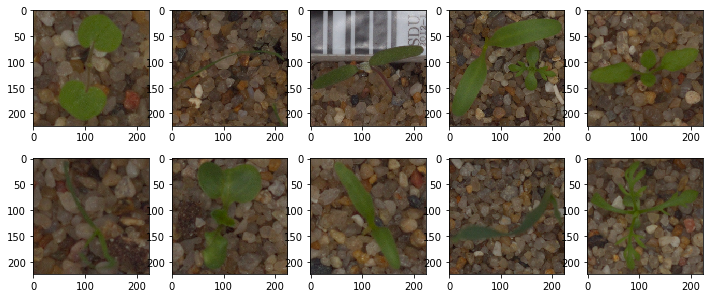

In [14]:
test_imgs = load_images("./data/test/raw/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         scale_up=True,
                         write_to="./data/test/resized")

plot_random_10(test_imgs)

del test_imgs

### Loading Test Data and Saved Model
Predictions will be made and saved to CSV for submission

In [15]:
test_imgs, file_names = load_images("./data/test/resized/*.png", return_file_paths=True)
test_imgs = np.array(test_imgs)
file_names = 

In [16]:
# create a new graph which differs slightly from the previous
inference_graph = tf.Graph()
with inference_graph.as_default():
    X = tf.placeholder(tf.float32, shape=(len(test_imgs), IMG_SIZE, IMG_SIZE, 3), name="X")
    dropout = tf.constant(0)

    model = AlexNet(X, dropout, num_classes)
    
    predictions = tf.argmax(model.logits, axis=1)
    
    saver = tf.train.Saver()
    
    # restore the model in this graph and see which predications were wrong
    with tf.Session() as sess:
        saver.restore(sess, "./tensorflow-ckpt/model.ckpt")
        test_predictions = sess.run(predictions, feed_dict={X: test_imgs})
        prediction_df = pd.DataFrame(data={"file": file_names, "species": np.array(class_names)[test_predictions]})
        display(prediction_df.head())
        prediction_df.to_csv("./test_predictions.csv", index=False)

INFO:tensorflow:Restoring parameters from ./tensorflow-ckpt/model.ckpt


,file,species
0,e19673dc9.png,Charlock
1,a8c8a1db0.png,Shepherds Purse
2,76dbd1054.png,Scentless Mayweed
3,148bbda66.png,Charlock
4,9c777333d.png,Shepherds Purse


### Model 4 - ResNet-50
Since the network may have been saturated, I'll try one with more parameters. ResNet-50 is an architecture by Google which achieved state-of-the-art performance on [ImageNet](http://www.image-net.org/) at the time of discovery. It was deeper than all previous contenders. The "residual connections" were credited to its success, allowing gradients to pass through more layers during training and enabling a deeper architecture. Another attractive quality is that a model implementation comes out of the box with Tensorflow, so there's no need to code it myself.

In [19]:
model = tf.keras.applications.ResNet50(weights=None, classes=12)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(train_data_aug_2, train_labels_aug_2,
          batch_size=64,
          epochs=10,
          shuffle=True,
          validation_data=(dev_data, dev_labels))

model.save('resnet50_model.h5')

Train on 64608 samples, validate on 712 samples
Epoch 1/10
64608/64608 [==============================]64608/64608 [==============================] - 668s 10ms/step - loss: 1.9780 - acc: 0.2958 - val_loss: 1.3007 - val_acc: 0.5239

Epoch 2/10
64608/64608 [==============================]64608/64608 [==============================] - 665s 10ms/step - loss: 0.4355 - acc: 0.8429 - val_loss: 0.3754 - val_acc: 0.8624

Epoch 3/10
64608/64608 [==============================]64608/64608 [==============================] - 666s 10ms/step - loss: 0.2129 - acc: 0.9186 - val_loss: 0.3005 - val_acc: 0.8975

Epoch 4/10
64608/64608 [==============================]64608/64608 [==============================] - 665s 10ms/step - loss: 0.1466 - acc: 0.9420 - val_loss: 0.3046 - val_acc: 0.9157

Epoch 5/10
64608/64608 [==============================]64608/64608 [==============================] - 664s 10ms/step - loss: 0.1089 - acc: 0.9581 - val_loss: 0.2690 - val_acc: 0.9284

Epoch 6/10
64608/64608 [========

In [20]:
test_predictions = np.argmax(model.predict(test_imgs), axis=1)
prediction_df = pd.DataFrame(data={"file": file_names, "species": np.array(class_names)[test_predictions]})
display(prediction_df.head())
prediction_df.to_csv("./test_predictions.csv", index=False)

,file,species
0,e19673dc9.png,Charlock
1,a8c8a1db0.png,Shepherds Purse
2,76dbd1054.png,Sugar beet
3,148bbda66.png,Charlock
4,9c777333d.png,Common Chickweed


After submitting, this produced 92% accuracy on the test data! This has been the best yet.

To improve further, I believe I'll need to gain some insights on the mistakes the model is making. I can plot some of the misclassified examples to find any commonalities amoung the mistakes. Perhaps there are better ways than scaling to handle the differing image sizes. For example, maybe padding rather than scaling is the best approach, but padding with generated soil background instead of zeros. For this, I could train a [GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network) to generate some background.